In [1]:
import vaft

Load and test sample thomson scattering files

In [4]:
import vaft
from pathlib import Path
from omas import *  
import matplotlib.pyplot as plt

# new_thomson = '46051_NeTe.mat'
# old_thomson = 'NeTe_Shot39915_v9_rev.mat'

# data_dir = Path(vaft.__file__).resolve().parent / "data"
# file_new = data_dir / new_thomson
# file_old = data_dir / old_thomson

# for f in [file_new, file_old]:
#     if f.is_file():
#         print(f"[FOUND] {f.name}")
#     else:
#         print(f"[MISSING] {f.name}")

ods_new_thomson = vaft.database.load(45414,'public')

# ods_new_thomson = ODS()
ods_old_thomson = ODS()

file_new = '/srv/vest.diagnostic/45414_NeTe.mat'
file_old = '/srv/vest.diagnostic/NeTe_Shot40323_v9_rev.mat'
vaft.machine_mapping.thomson_scattering(ods_new_thomson, 46051, file_new)
vaft.machine_mapping.thomson_scattering(ods_old_thomson, 39915, file_old)

print("[INFO] Thomson data successfully loaded into ODS structures.")

vaft.plot.plot_thomson_time_series(ods_new_thomson)
vaft.plot.plot_thomson_time_series(ods_old_thomson)

OSError: [Errno 404] Not Found

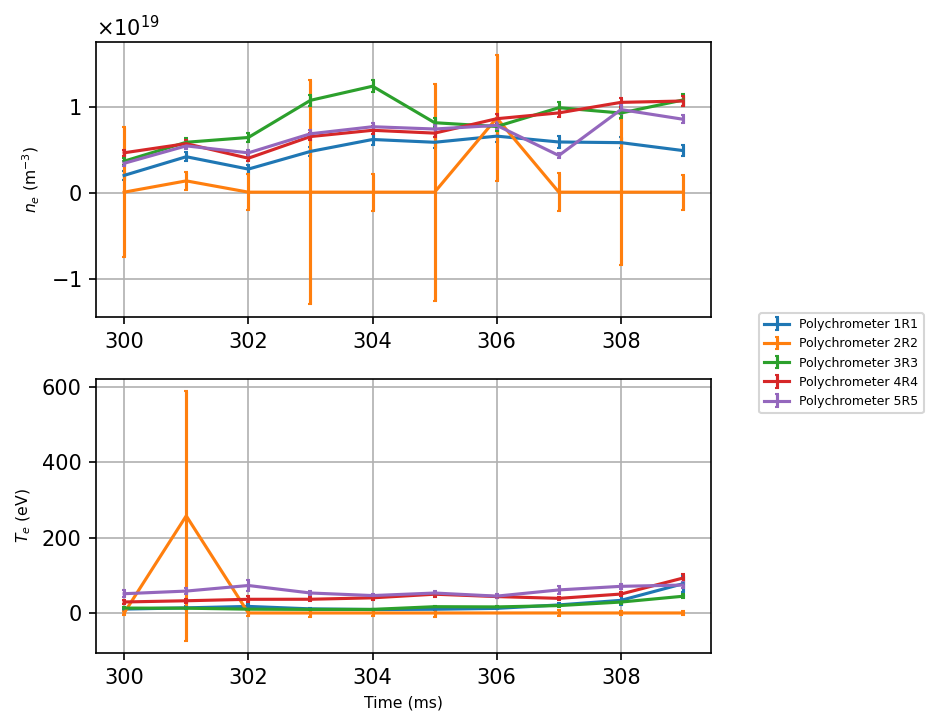

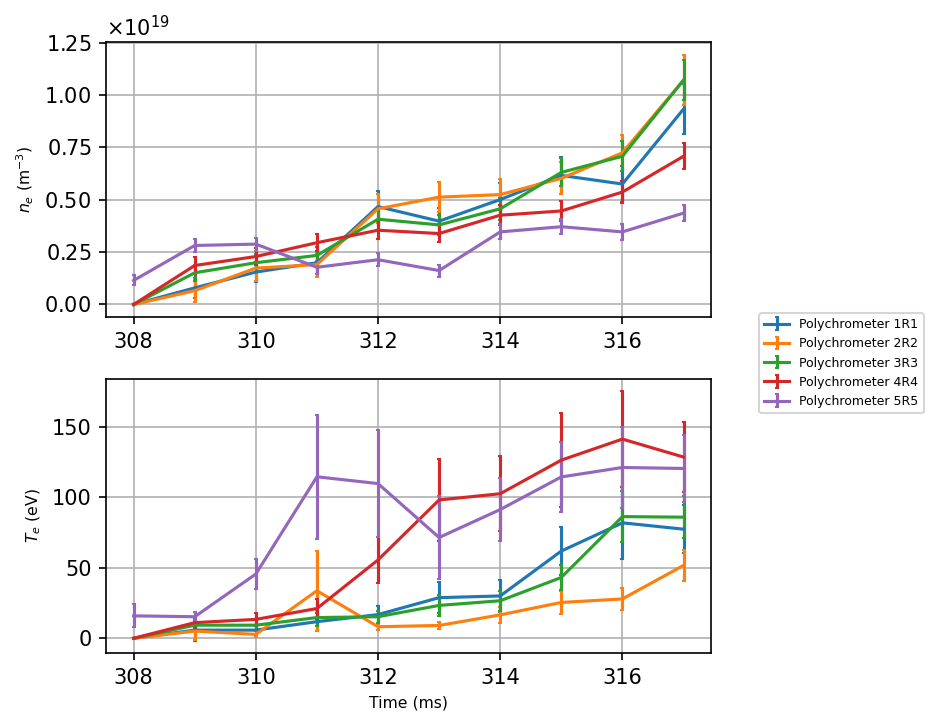

In [2]:
df= vaft.database.exist_ts_file()

Available Thomson Scattering Shots:

|   Index |   Shot Number | Last Processed                | Status          |
|---------|---------------|-------------------------------|-----------------|
|       1 |         22027 | b'2023-02-02T23:24:20'        | b'invalid'      |
|       2 |         39513 | b'2024-08-06T11:18:45.556514' | b'invalid'      |
|       3 |         39515 | b'2024-08-06T11:19:39.748631' | b'invalid'      |
|       4 |         39906 | b'2024-08-06T11:20:05.668157' | b'invalid'      |
|       5 |         39915 | b'2024-05-14T16:42:35.439538' | b'invalid'      |
|       6 |         39916 | b'2024-07-08T20:11:09.953256' | b'invalid'      |
|       7 |         39917 | b'2023-07-05T20:47:14'        | b'core_profile' |
|       8 |         40282 | b'2024-08-06T11:20:28.826835' | b'invalid'      |
|       9 |         40323 | b'2023-07-28T16:03:45'        | b'invalid'      |
|      10 |         40324 | b'2023-07-28T16:05:23'        | b'thomson_only' |
|      11 |         40325 |

In [8]:
ods = vaft.database.load(40330)

Successfully loaded ODS data for shot: 40330


[INFO] Using equilibrium time slice 0


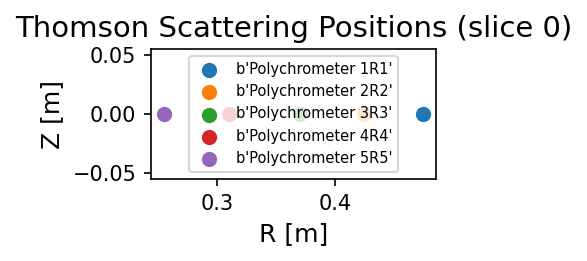

In [5]:
vaft.plot.plot_thomson_radial_position(ods)

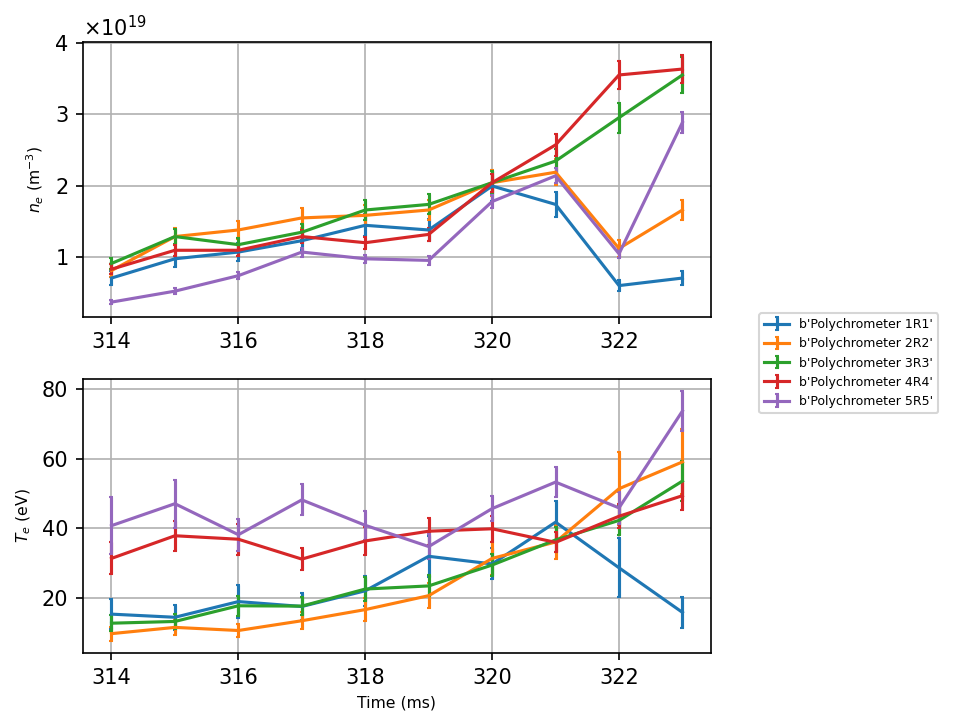

In [ ]:
vaft.plot.plot_thomson_time_series(ods)

[INFO] Found 4 fitted core_profiles


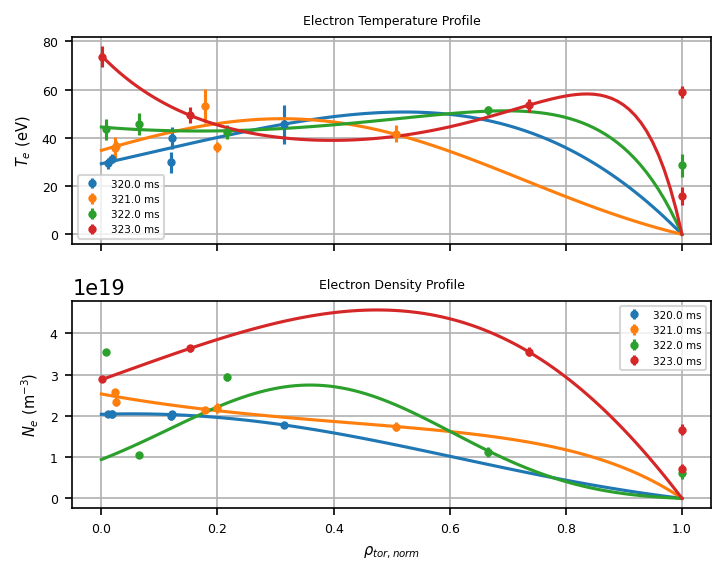

In [ ]:
vaft.plot.plot_thomson_profiles(ods)